In [1]:
import os
import gensim
from gensim.models import Word2Vec

import jieba
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.font_manager
from wordcloud import WordCloud

# 全局变量

In [18]:
# 全局常量
FILE_PATH = 'D:\doc\课业\研一下\DeepNLP\hw3\code\data'
STOPWORDS_PATH = 'D:\doc\课业\研一下\DeepNLP\hw3\code\cn_stopwords.txt'
FONT_PATH = 'D:\doc\课业\研一下\DeepNLP\hw3\simsun.ttc'

In [19]:
# 准备人物名字列表
CHARACTER_NAMES = [
    '郭靖', '黄蓉', '杨过', '赵敏', '张无忌', '张翠山', '郭襄', '小龙女', '武三通', '周芷若',
    '乔峰', '段誉', '虚竹', '萧峰', '木婉清', '令狐冲', '林平之', '岳不群', '任我行', '任盈盈', 
    '东方不败', '谢逊', '宋青书', '梅超风', '慕容复', '段正淳', '灭绝师太', '岳灵珊', '柯镇恶', 
    '欧阳锋', '王语嫣', '鸠摩智', '洪七公', '裘千仞', '一灯大师', '周伯通', '陆无双', '金轮法王', 
    '赵志敬', '李莫愁'
]

# 预训练数据

In [20]:
def load_data(file_path, stopwords_path):
    """
    加载并预处理数据

    参数:
        file_path (str): 数据文件夹路径
        stopwords_path (str): 停用词文件路径

    返回:
        tuple: 处理后的文本数据和词频统计
    """
    stop_words = []
    with open(stopwords_path, 'r', encoding='utf-8') as stopword_file:
        stop_words.extend([line.strip() for line in stopword_file.readlines()])
    
    text = []
    word_counter = Counter()
    for file in os.listdir(file_path):
        with open(os.path.join(file_path, file), 'r', encoding='gb18030') as f:
            for line in f:
                line = line.replace('----〖新语丝电子文库(www.xys.org)〗', '')
                line = line.replace('本书来自www.cr173.com免费txt小说下载站', '')
                line = line.replace('更多更新免费电子书请关注www.cr173.com', '')
                words = jieba.lcut(line)
                words = [word for word in words if word.isalnum() and word not in stop_words]
                word_counter.update(words)
                if words:
                    text.append(words)
    return text, word_counter

In [21]:
 # 步骤1：加载并预处理数据
text, word_counter = load_data(FILE_PATH, STOPWORDS_PATH)

# 只保留最常见的词里面的人物名字
invest_words = [word for word, _ in word_counter.most_common(100) if word in CHARACTER_NAMES]
print(f"提取的人物名字: {invest_words}")

提取的人物名字: ['令狐冲', '张无忌', '杨过', '郭靖', '黄蓉']


# 训练Word2Vec模型

In [22]:
def train_word2vec_model(sentences, sg=0, vector_size=200, window=5, min_count=5, epochs=50, negative=10):
    """
    训练Word2Vec模型

    参数:
        sentences (list): 句子列表
        sg (int): Skip-gram（1）或CBOW（0）模型
        vector_size (int): 词向量维度
        window (int): 窗口大小
        min_count (int): 忽略频率低于此值的单词
        epochs (int): 训练轮数
        negative (int): 负采样数量

    返回:
        gensim.models.Word2Vec: 训练好的Word2Vec模型
    """
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs, negative=negative, sg=sg)
    return model

In [23]:
# 模型
model = train_word2vec_model(text,sg=1, vector_size=200, window=5, min_count=5, epochs=50,negative=10)


# 词向量验证

## 验证词向量有效性

In [35]:
def find_similar_words(model, word, topn=20):
    """
    查找与给定词语最相似的词语

    参数:
        model (gensim.models.Word2Vec): 训练好的Word2Vec模型
        word (str): 基准词语
        topn (int): 返回相似词语的数量

    返回:
        list: 与基准词语最相似的词语列表
    """
    try:
        return model.wv.most_similar(word, topn=topn)
    except KeyError as e:
        print(f"词汇 '{e.args[0]}' 不在词汇表中。")
        return []

In [26]:
similar_words = find_similar_words(model, '令狐冲')
print(f"与 令狐冲 最相似的词语: {similar_words}")

与 令狐冲 最相似的词语: [('盈盈', 0.67405104637146), ('岳不群', 0.6531205177307129), ('田伯光', 0.6261542439460754), ('仪琳', 0.6126452684402466), ('岳灵珊', 0.5847568511962891), ('林平之', 0.5810838937759399), ('岳夫人', 0.5606328845024109), ('左冷禅', 0.5591430068016052), ('恒山', 0.552461564540863), ('向问天', 0.5276910066604614), ('任我行', 0.5247212052345276), ('令狐大哥', 0.5163977742195129), ('令狐掌门', 0.49427223205566406), ('定逸', 0.49274083971977234), ('方证', 0.4881463348865509), ('冲虚', 0.48758023977279663), ('婆婆', 0.48339977860450745), ('劳德诺', 0.4754582345485687), ('桃谷六仙', 0.47283104062080383), ('华山派', 0.4667283296585083)]


### 词云

In [37]:
def generate_wordcloud(words, ax, title, font_properties):
    """
    生成词云

    参数:
        words (dict): 词语及其对应频率
        ax (matplotlib.axes._subplots.AxesSubplot): 轴对象
        title (str): 标题
        font_properties (FontProperties): 字体属性
    """
    wordcloud = WordCloud(font_path=FONT_PATH, background_color='white').generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title, fontproperties=font_properties)

与 令狐冲 最相似的词语:
盈盈: 0.67405104637146
岳不群: 0.6531205177307129
田伯光: 0.6261542439460754
仪琳: 0.6126452684402466
岳灵珊: 0.5847568511962891
林平之: 0.5810838937759399
岳夫人: 0.5606328845024109
左冷禅: 0.5591430068016052
恒山: 0.552461564540863
向问天: 0.5276910066604614
与 张无忌 最相似的词语:
周芷若: 0.7448011040687561
赵敏: 0.7409756779670715
谢逊: 0.5910287499427795
宋青书: 0.5488066077232361
蛛儿: 0.5407360792160034
张三丰: 0.5272189378738403
小昭: 0.5246530771255493
金花婆婆: 0.5231675505638123
殷天正: 0.5164141654968262
殷梨亭: 0.5143828988075256
与 杨过 最相似的词语:
小龙女: 0.8049814105033875
黄蓉: 0.6758148670196533
郭靖: 0.6474983096122742
李莫愁: 0.6374943256378174
金轮法王: 0.6061658263206482
郭襄: 0.6007285118103027
欧阳锋: 0.598090410232544
陆无双: 0.5958625078201294
法王: 0.5943625569343567
周伯通: 0.5831406116485596
与 郭靖 最相似的词语:
黄蓉: 0.7406020164489746
杨过: 0.6474983096122742
欧阳锋: 0.598444938659668
郭靖道: 0.5827987790107727
蓉: 0.5695769786834717
黄药师: 0.5564329624176025
洪七公: 0.5493118166923523
柯镇恶: 0.529493510723114
欧阳克: 0.5137401223182678
拖雷: 0.5132470726966858
与 段誉 最

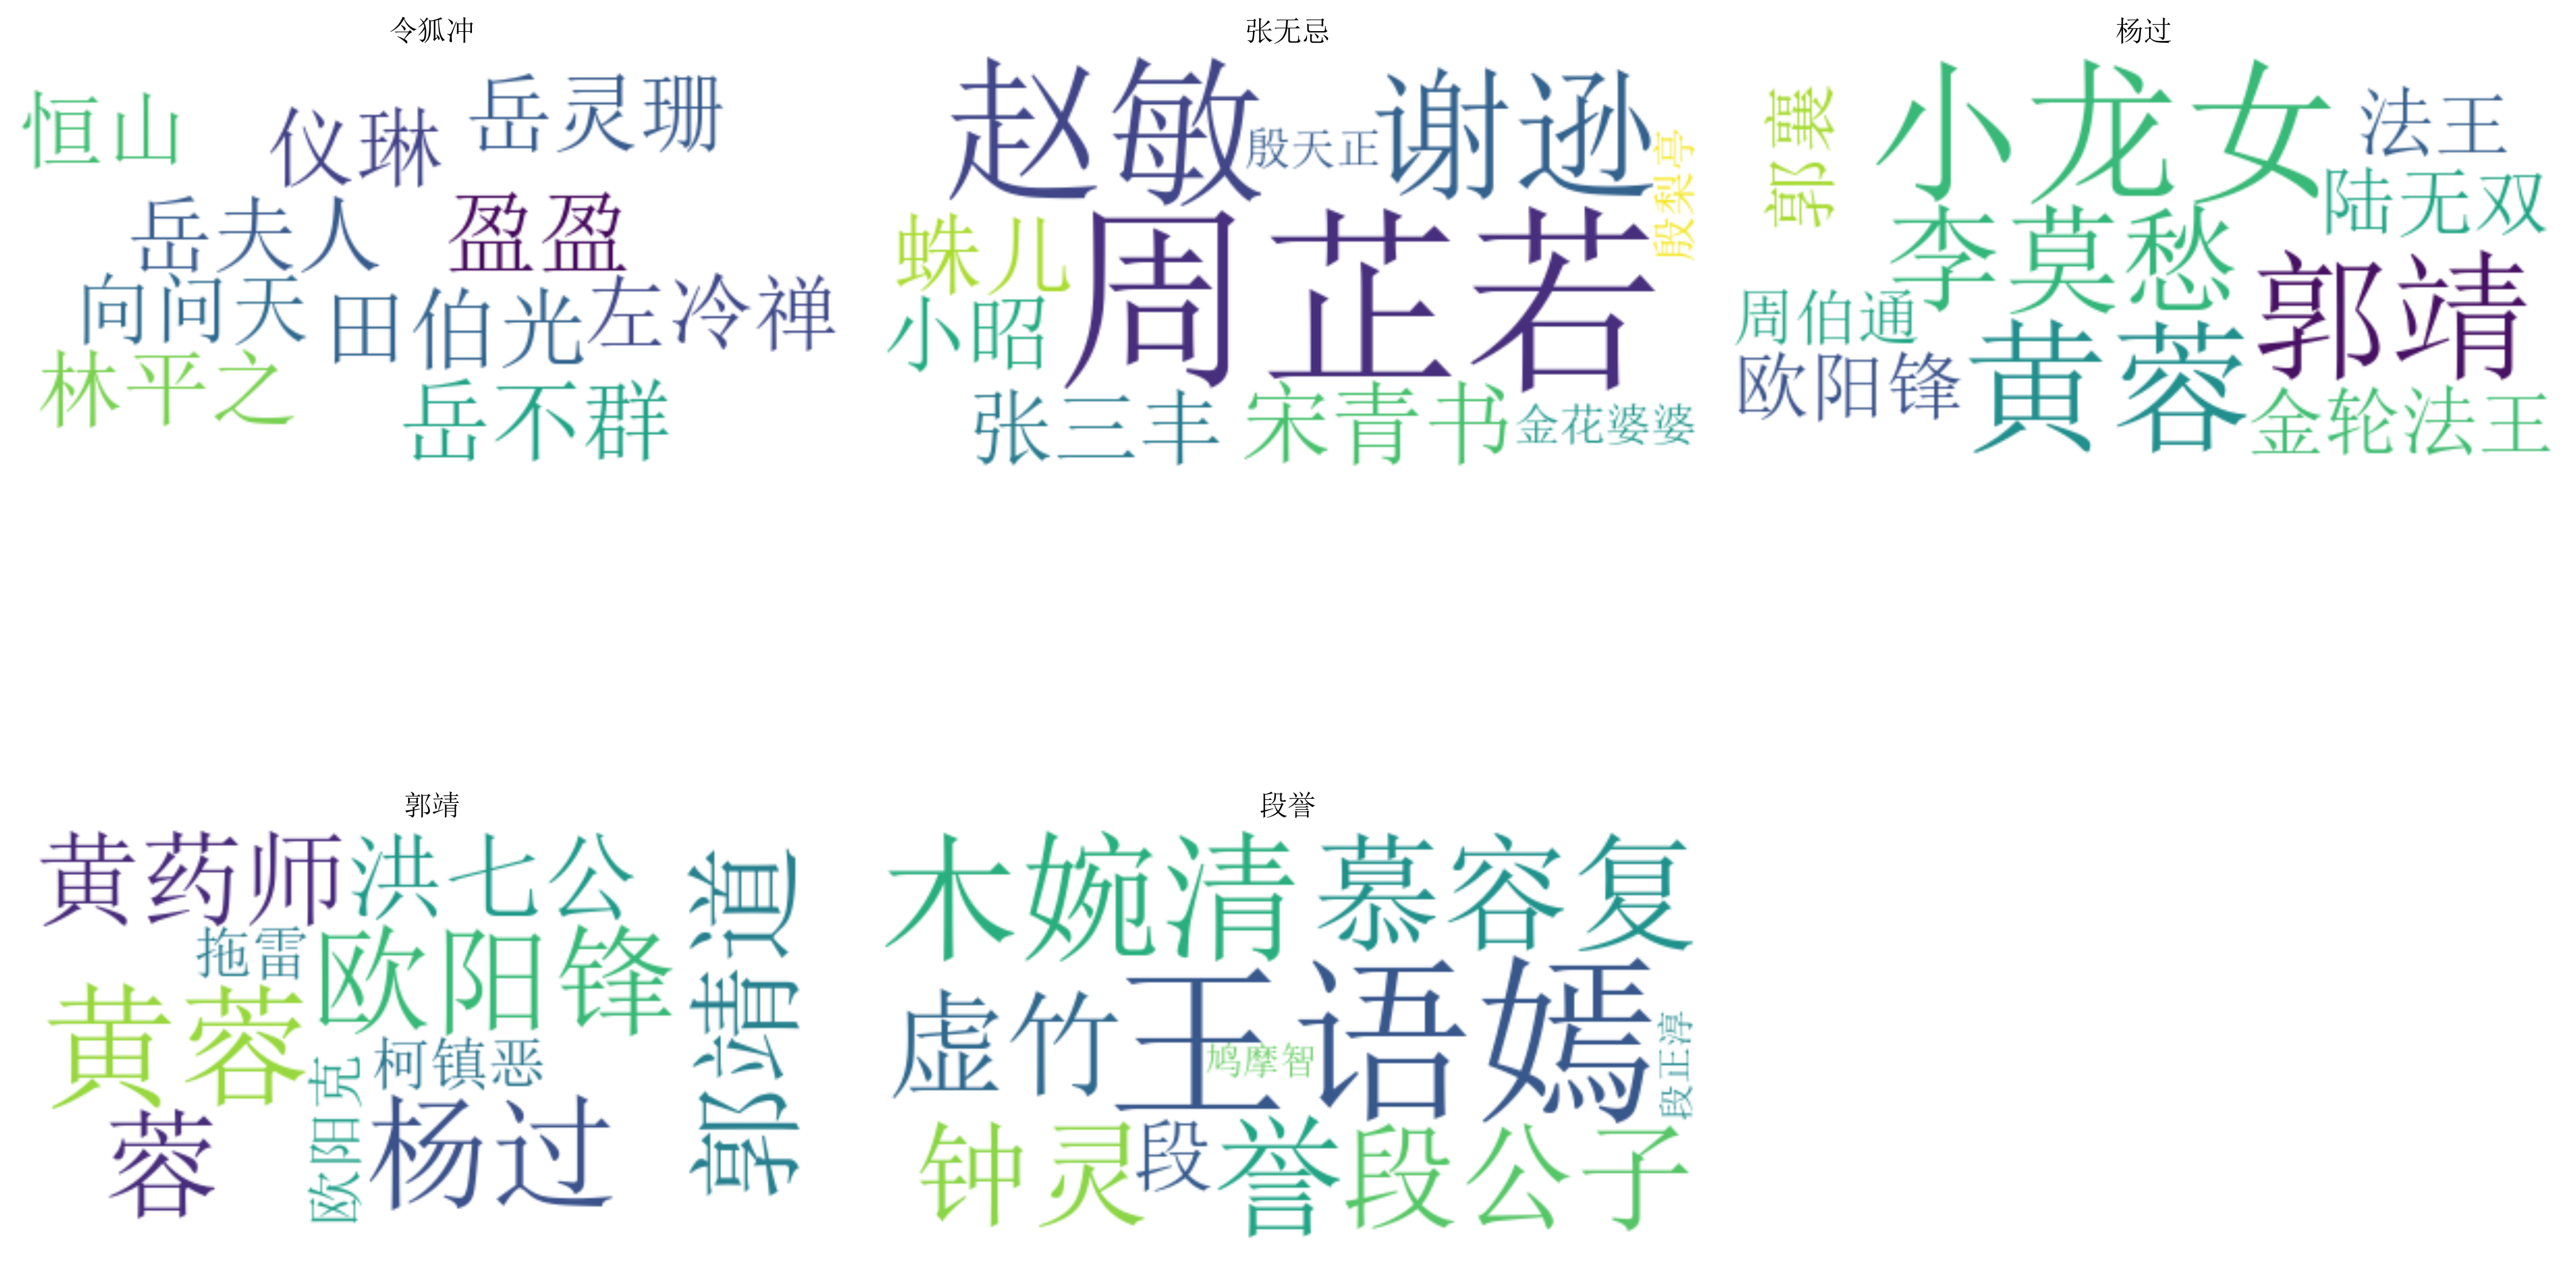

In [39]:
# 查找相似词语并生成词云
characters = ['令狐冲', '张无忌', '杨过', '郭靖', '段誉']
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
zhfont = matplotlib.font_manager.FontProperties(fname=FONT_PATH, size=12)

for ax, character in zip(axs.flatten(), characters):
    print(f"与 {character} 最相似的词语:")
    similar_words = find_similar_words(model, character, topn=10)
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
    # 生成词云
    words_freq = {word: similarity for word, similarity in similar_words}
    generate_wordcloud(words_freq, ax, character, zhfont)

# 删除多余的子图
for i in range(len(characters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

### 条形图

In [41]:
def generate_barchart(words, ax, title, font_properties):
    """
    生成条形图

    参数:
        words (dict): 词语及其对应频率
        ax (matplotlib.axes._subplots.AxesSubplot): 轴对象
        title (str): 标题
        font_properties (FontProperties): 字体属性
    """
    words_sorted = sorted(words.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*words_sorted)

    ax.bar(labels, values, color='skyblue')
    ax.set_title(title, fontproperties=font_properties)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontproperties=font_properties)

    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontproperties=font_properties)

C:\Users\cjy\AppData\Local\Temp\ipykernel_23356\2142127787.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontproperties=font_properties)
C:\Users\cjy\AppData\Local\Temp\ipykernel_23356\2142127787.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontproperties=font_properties)
C:\Users\cjy\AppData\Local\Temp\ipykernel_23356\2142127787.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontproperties=font_properties)
C:\Users\cjy\AppData\Local\Temp\ipykernel_23356\2142127787.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

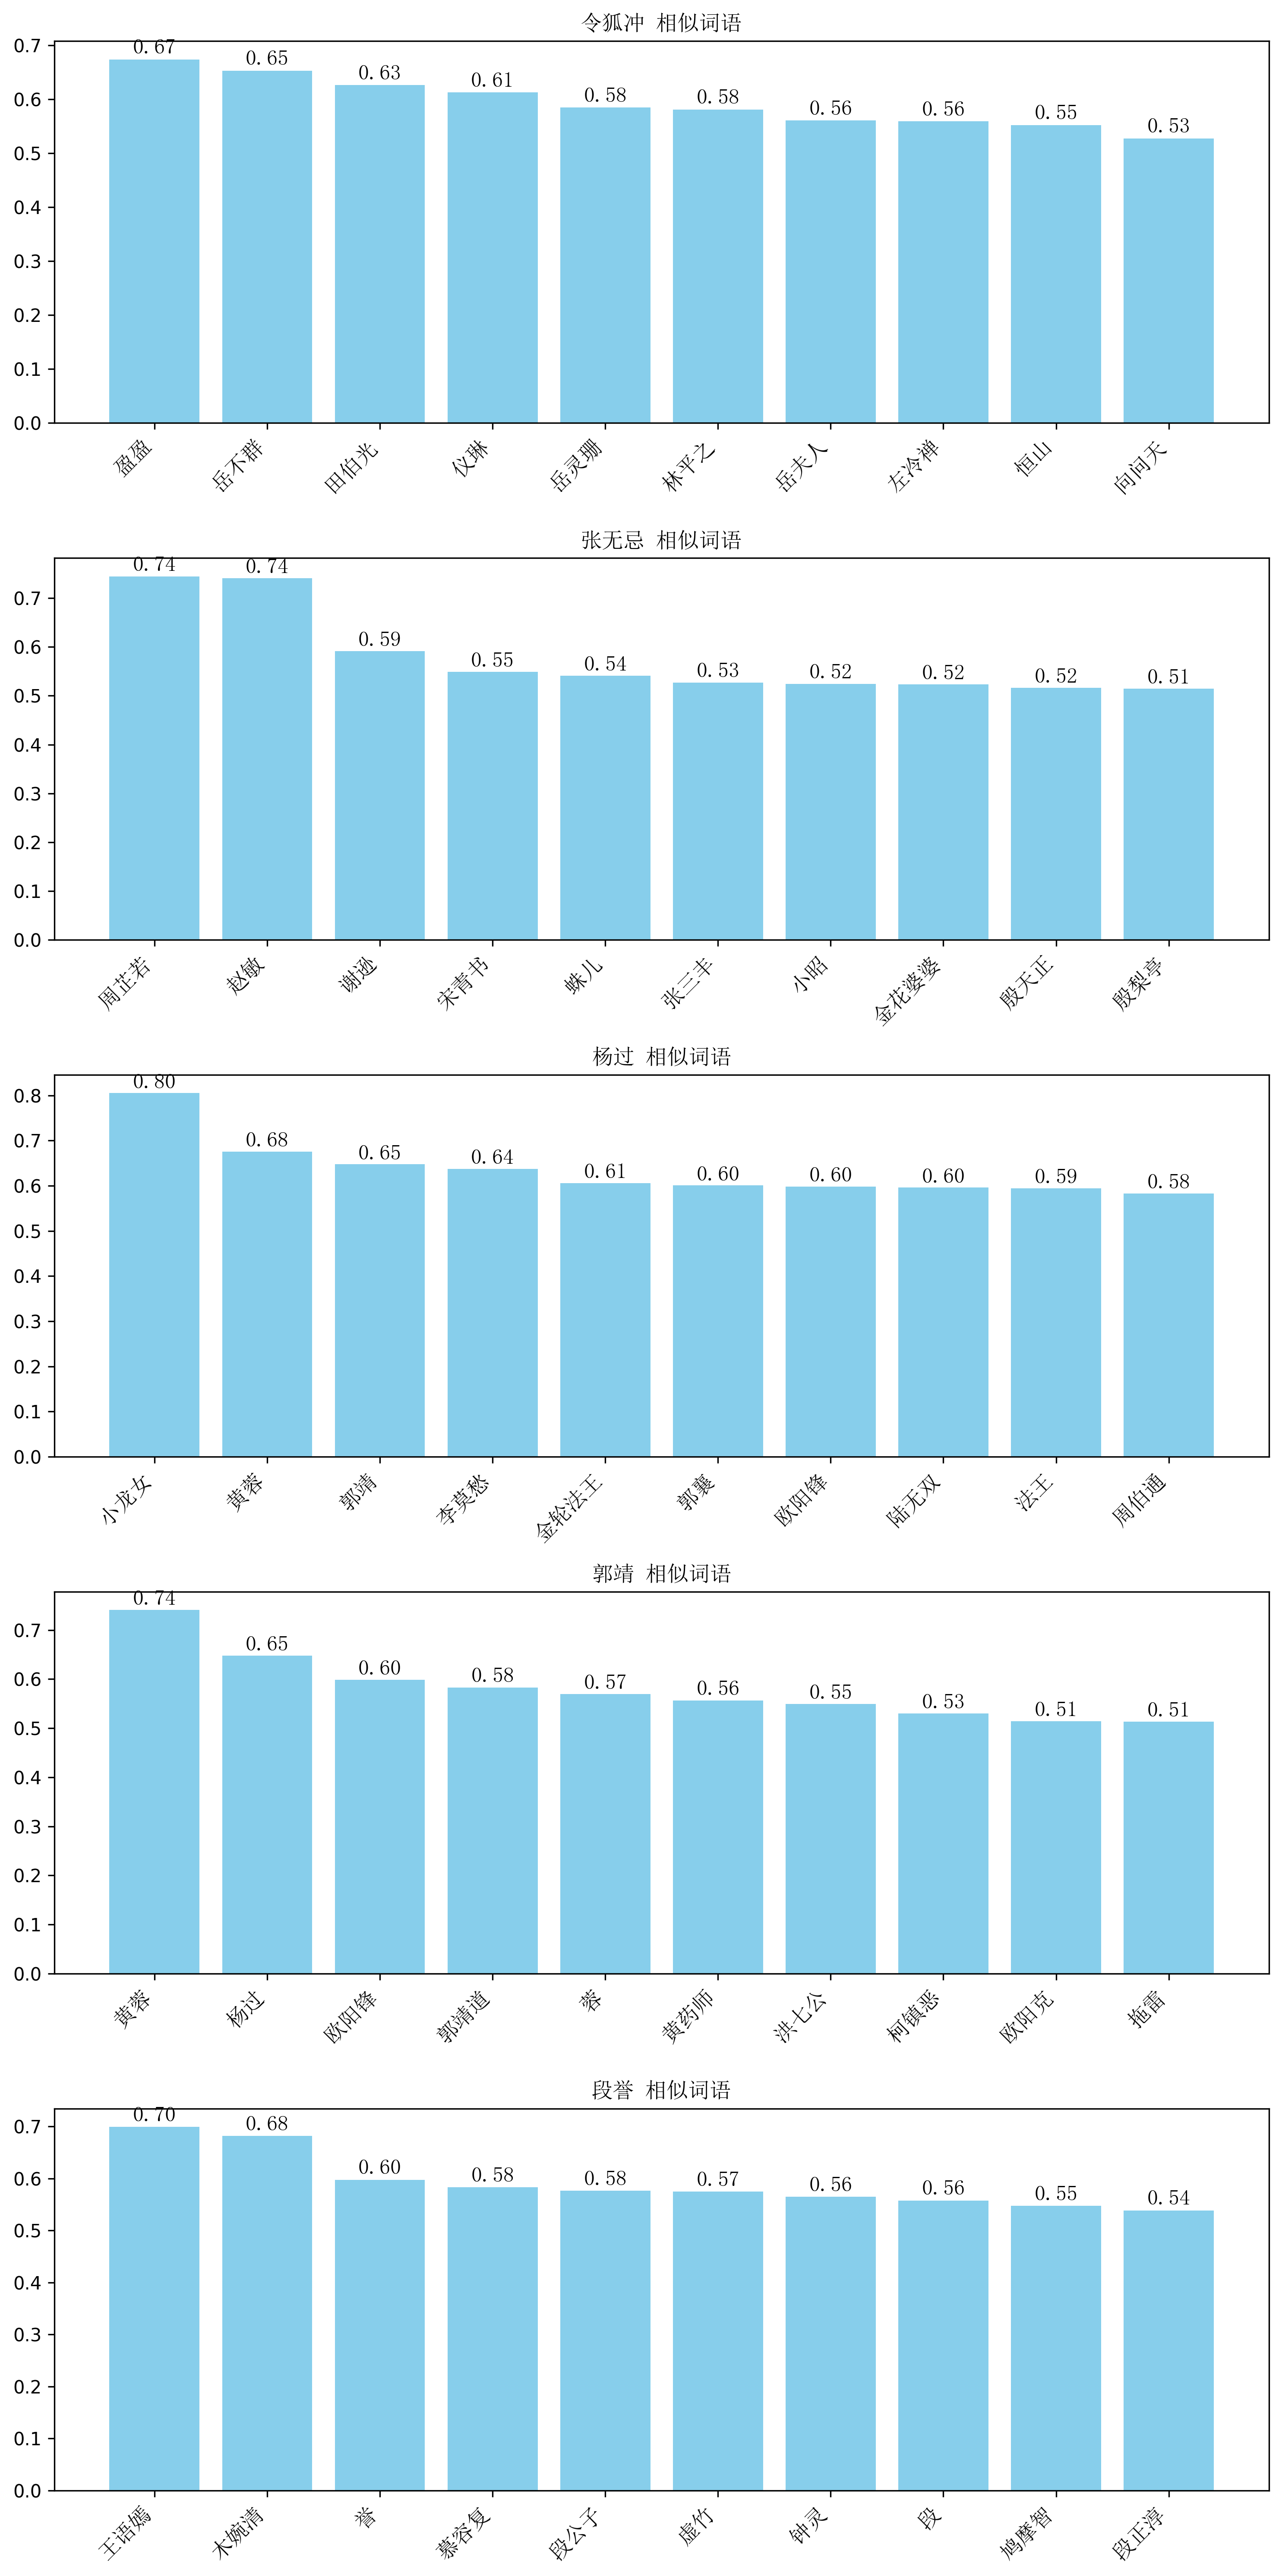

In [48]:
characters = ['令狐冲', '张无忌', '杨过', '郭靖', '段誉']

# 生成条形图
fig, axs = plt.subplots(len(characters), 1, figsize=(10, 20), dpi=300)

for ax, character in zip(axs, characters):
    similar_words = find_similar_words(model, character, topn=10)
    words_freq = {word: similarity for word, similarity in similar_words}
    generate_barchart(words_freq, ax, f"{character} 相似词语", zhfont)

plt.tight_layout()
plt.show()

## 计算两个词语的相似度

In [52]:
def compute_similarity(model, word1, word2, mode='cos'):
    """
    计算两个词语的相似度

    参数:
        model (gensim.models.Word2Vec): 训练好的Word2Vec模型
        word1 (str): 第一个词
        word2 (str): 第二个词
        mode (str): 相似度计算方式（'cos'或'euclidean'）

    返回:
        float: 相似度得分
    """
    try:
        if mode == 'cos':
            return model.wv.similarity(word1, word2)
        elif mode == 'euclidean':
            vec1 = model.wv.get_vector(word1)
            vec2 = model.wv.get_vector(word2)
            return np.linalg.norm(vec1 - vec2)
    except KeyError as e:
        print(f"词汇 '{e.args[0]}' 不在词汇表中。")
        return None

In [53]:
# 计算词语相似度
similarity = compute_similarity(model, '郭靖', '黄蓉')
print(f"郭靖 和 黄蓉 的相似度: {similarity}")

郭靖 和 黄蓉 的相似度: 0.7406020760536194


## 聚类分析


In [13]:
def cluster_words(model, word_list, num_clusters=3):
    """
    对词语进行聚类分析

    参数:
        model (gensim.models.Word2Vec): 训练好的Word2Vec模型
        word_list (list): 词语列表
        num_clusters (int): 聚类数量

    返回:
        tuple: 词向量和KMeans聚类模型
    """
    vectors = [model.wv[word] for word in word_list if word in model.wv]
    word_vectors = np.array(vectors, dtype=float)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(word_vectors)
    return word_vectors, kmeans

In [50]:
def visualize_clusters(words, word_vectors, kmeans):
    """
    可视化词语的聚类结果

    参数:
        words (list): 词语列表
        word_vectors (numpy.ndarray): 词向量
        kmeans (sklearn.cluster.KMeans): KMeans聚类模型
    """
    font_properties = matplotlib.font_manager.FontProperties(fname=FONT_PATH, size=12)
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(word_vectors)

    plt.figure(figsize=(10, 10), dpi =300)
    for i, vector in enumerate(reduced_vectors):
        plt.scatter(vector[0], vector[1], c=f'C{kmeans.labels_[i]}')
        plt.text(vector[0], vector[1], words[i], fontproperties=font_properties, alpha=1, color='black')
    plt.show()


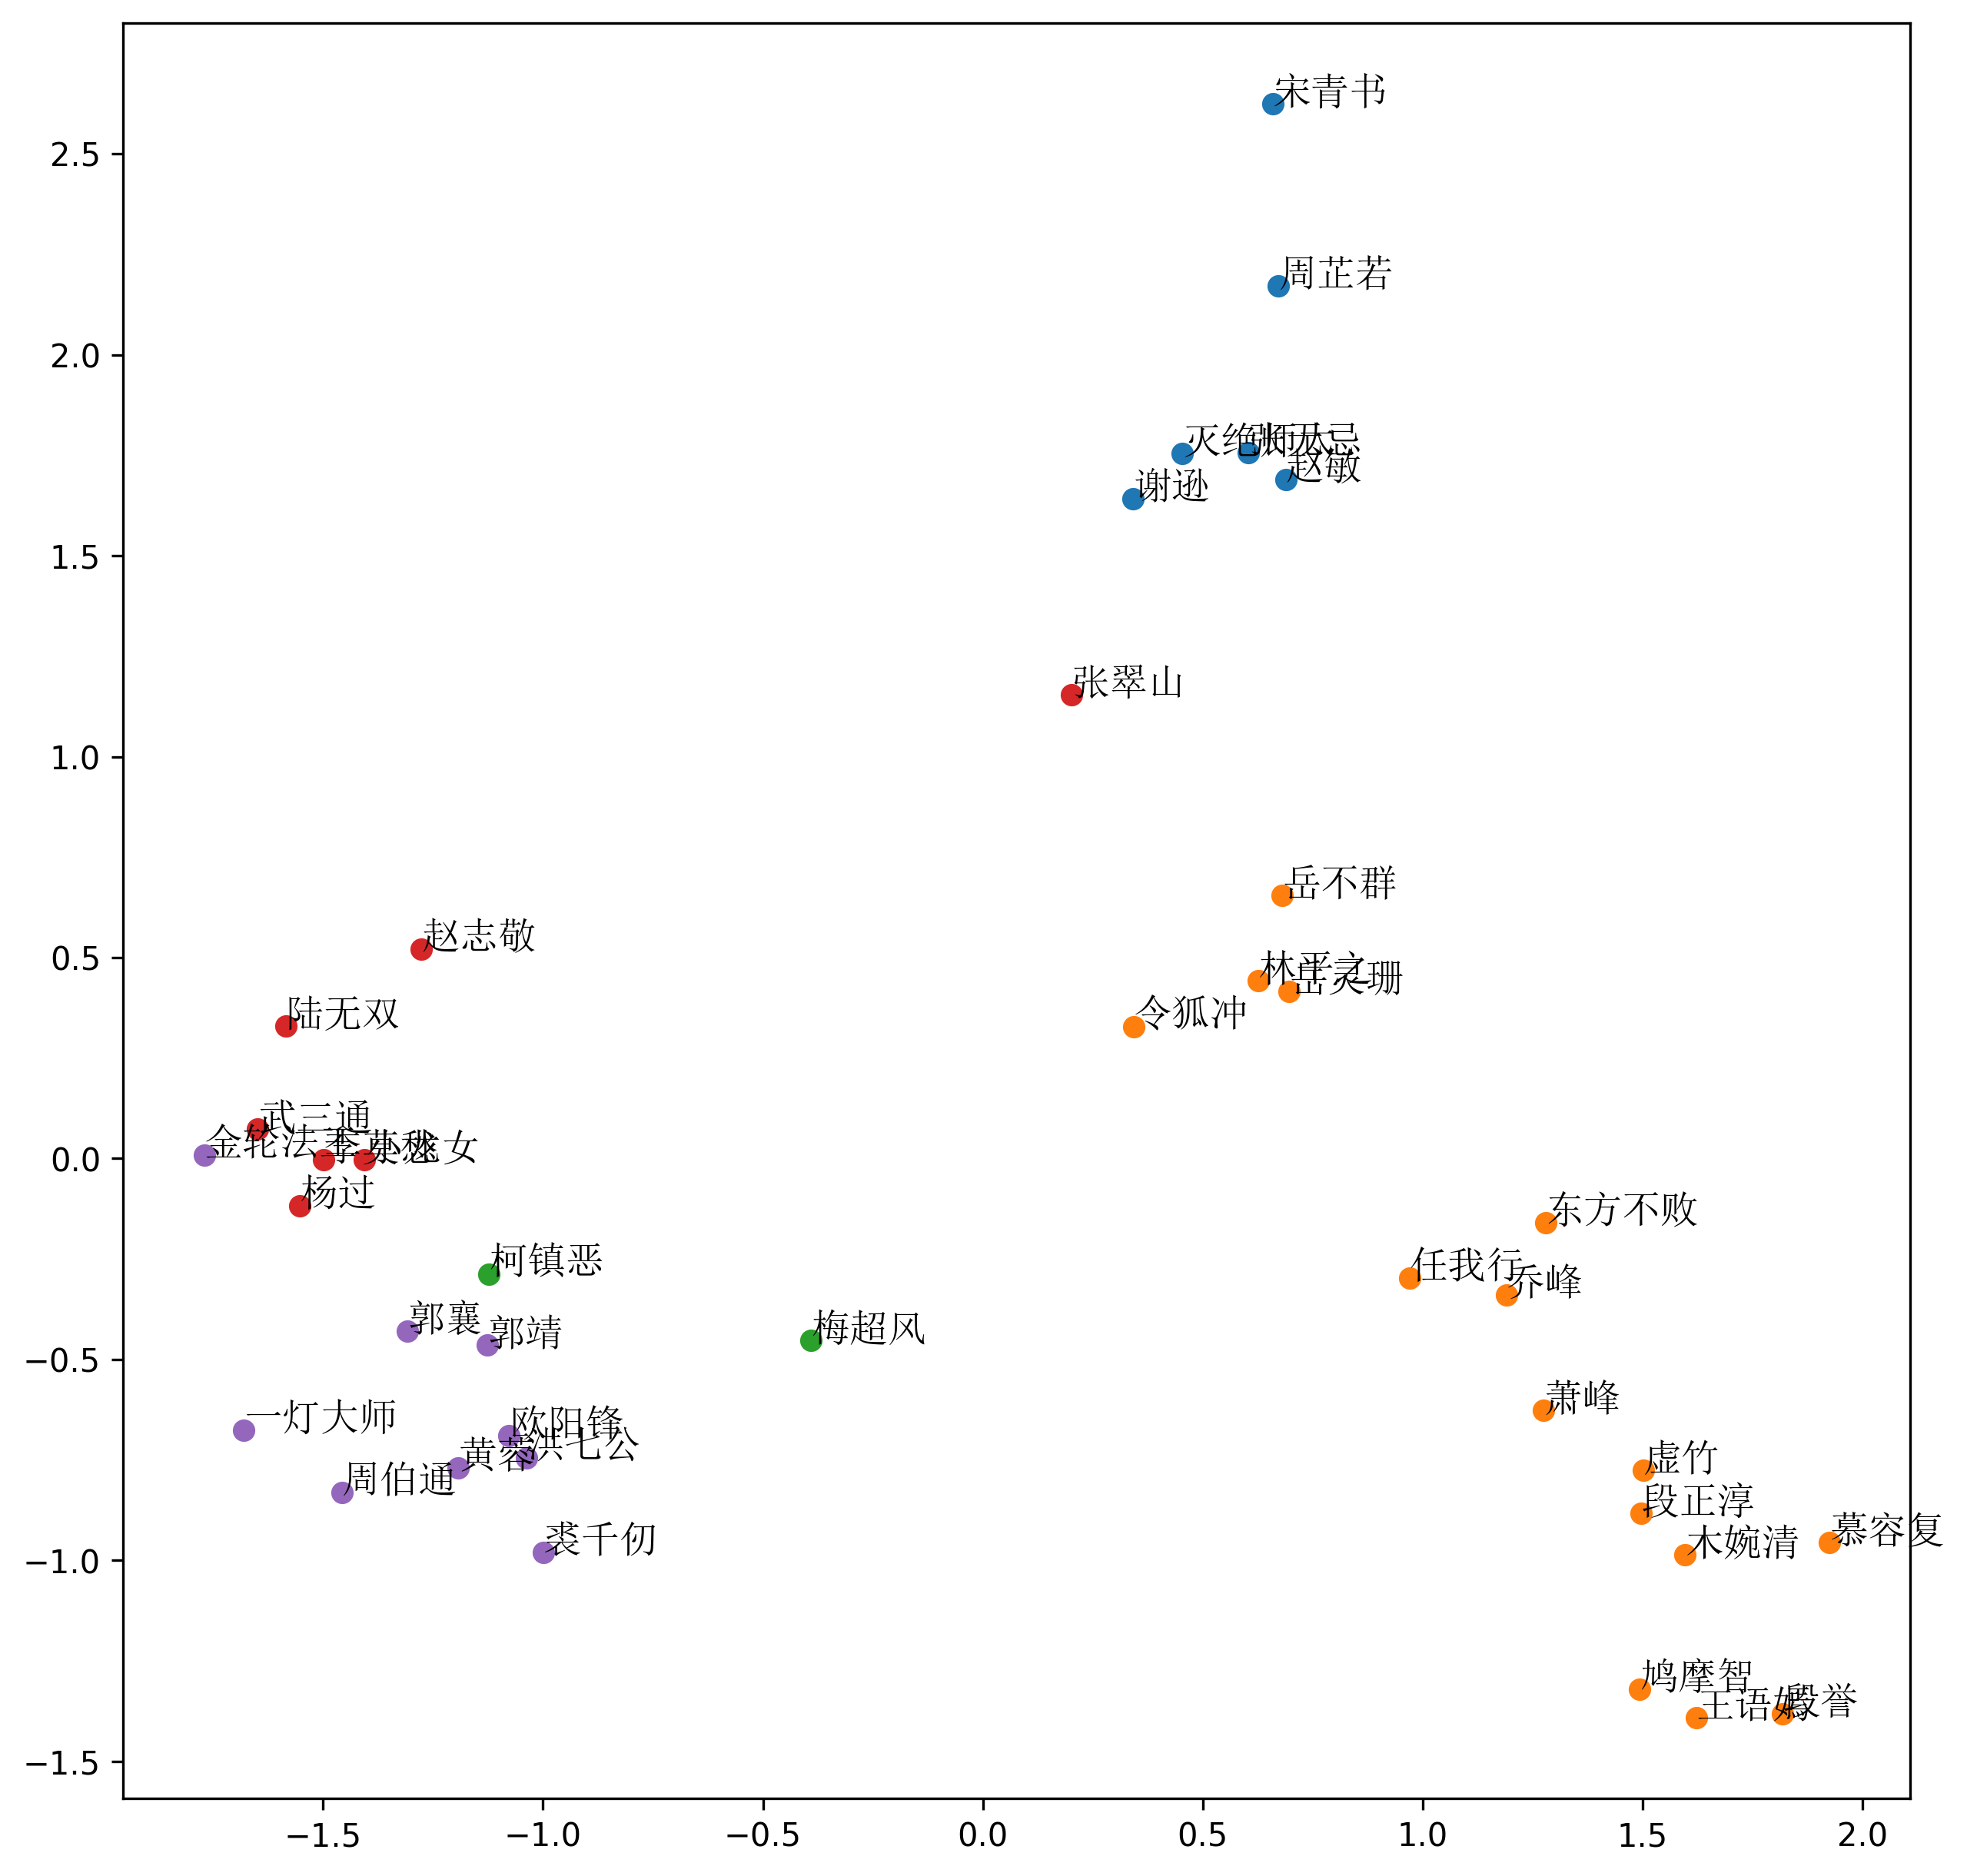

Cluster 0 purity: 1.00, elements: ['赵敏', '张无忌', '周芷若', '谢逊', '宋青书', '灭绝师太'], dominant book: 倚天屠龙记
Cluster 1 purity: 0.60, elements: ['乔峰', '段誉', '虚竹', '萧峰', '木婉清', '令狐冲', '林平之', '岳不群', '任我行', '东方不败', '慕容复', '段正淳', '岳灵珊', '王语嫣', '鸠摩智'], dominant book: 天龙八部
Cluster 2 purity: 1.00, elements: ['梅超风', '柯镇恶'], dominant book: 射雕英雄传
Cluster 3 purity: 0.71, elements: ['杨过', '张翠山', '小龙女', '武三通', '陆无双', '赵志敬', '李莫愁'], dominant book: 神雕侠侣
Cluster 4 purity: 0.78, elements: ['郭靖', '黄蓉', '郭襄', '欧阳锋', '洪七公', '裘千仞', '一灯大师', '周伯通', '金轮法王'], dominant book: 射雕英雄传


In [51]:
from collections import Counter


# 定义每个人物所属的书籍
character_books = {
    '郭靖': '射雕英雄传', '黄蓉': '射雕英雄传', '杨过': '神雕侠侣', '赵敏': '倚天屠龙记', 
    '张无忌': '倚天屠龙记', '张翠山': '倚天屠龙记', '郭襄': '神雕侠侣', '小龙女': '神雕侠侣', 
    '武三通': '射雕英雄传', '周芷若': '倚天屠龙记', '乔峰': '天龙八部', '段誉': '天龙八部', 
    '虚竹': '天龙八部', '萧峰': '天龙八部', '木婉清': '天龙八部', '令狐冲': '笑傲江湖', 
    '林平之': '笑傲江湖', '岳不群': '笑傲江湖', '任我行': '笑傲江湖', '东方不败': '笑傲江湖', 
    '谢逊': '倚天屠龙记', '宋青书': '倚天屠龙记', '梅超风': '射雕英雄传', '慕容复': '天龙八部', 
    '段正淳': '天龙八部', '灭绝师太': '倚天屠龙记', '岳灵珊': '笑傲江湖', '柯镇恶': '射雕英雄传', 
    '欧阳锋': '射雕英雄传', '王语嫣': '天龙八部', '鸠摩智': '天龙八部', '洪七公': '射雕英雄传', 
    '裘千仞': '射雕英雄传', '一灯大师': '射雕英雄传', '周伯通': '射雕英雄传', '陆无双': '神雕侠侣', 
    '金轮法王': '神雕侠侣', '赵志敬': '神雕侠侣', '李莫愁': '神雕侠侣'
}

# 聚类分析
invest_words = [
    '郭靖', '黄蓉', '杨过', '赵敏', '张无忌', '张翠山', '郭襄', '小龙女', '武三通', '周芷若',
    '乔峰', '段誉', '虚竹', '萧峰', '木婉清', '令狐冲', '林平之', '岳不群', '任我行', 
    '东方不败', '谢逊', '宋青书', '梅超风', '慕容复', '段正淳', '灭绝师太', '岳灵珊', '柯镇恶', 
    '欧阳锋', '王语嫣', '鸠摩智', '洪七公', '裘千仞', '一灯大师', '周伯通', '陆无双', '金轮法王', 
    '赵志敬', '李莫愁'
]

word_vectors, kmeans = cluster_words(model, invest_words, num_clusters=5)
visualize_clusters(invest_words, word_vectors, kmeans)

# 计算每个聚类的纯度
def compute_cluster_purity(kmeans, invest_words, character_books):
    cluster_labels = kmeans.labels_
    cluster_purity = {}
    for cluster_id in np.unique(cluster_labels):
        cluster_elements = [invest_words[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_id]
        book_counts = Counter([character_books[elem] for elem in cluster_elements])
        total_elements = len(cluster_elements)
        max_count = max(book_counts.values())
        purity = max_count / total_elements
        cluster_purity[cluster_id] = purity
        print(f"Cluster {cluster_id} purity: {purity:.2f}, elements: {cluster_elements}, dominant book: {book_counts.most_common(1)[0][0]}")
    return cluster_purity

# 计算并输出聚类纯度
cluster_purity = compute_cluster_purity(kmeans, invest_words, character_books)


## 段落相似度

In [56]:
import random
# 定义函数以从文件中加载句子
def load_sentences(file_path):
    sentences = []
    with open(file_path, 'r', encoding='gb18030') as f:
        for line in f:
            line = line.strip()
            if line:  # 去除空行
                sentences.append(line)
    return sentences

# 定义随机抽取句子的函数
def get_random_sentence(sentences):
    return random.choice(sentences)

# 训练Word2Vec模型的函数（假设之前已经定义）

# 定义句子相似度计算函数
def compute_sentence_similarity(model, sentence1, sentence2):
    def get_sentence_vector(sentence):
        words = jieba.lcut(sentence)
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) == 0:  # 防止空句子或无词向量的情况
            return np.zeros(model.vector_size)
        sentence_vector = np.mean(word_vectors, axis=0)
        return sentence_vector

    vector1 = get_sentence_vector(sentence1)
    vector2 = get_sentence_vector(sentence2)
    
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity



### 相同文章

In [80]:
# 从原文中加载句子
sentences_gjx = load_sentences('D:\doc\课业\研一下\DeepNLP\hw3\code\data\倚天屠龙记.txt')
sentences_ygr = load_sentences('D:\doc\课业\研一下\DeepNLP\hw3\code\data\倚天屠龙记.txt')
sentences_lfh = load_sentences('D:\doc\课业\研一下\DeepNLP\hw3\code\data\倚天屠龙记.txt')

# 随机抽取一些示例句子
sentence1 = get_random_sentence(sentences_gjx)
sentence2 = get_random_sentence(sentences_ygr)
sentence3 = get_random_sentence(sentences_lfh)
# 计算句子之间的相似度
similarity1 = compute_sentence_similarity(model, sentence1, sentence2)
similarity2 = compute_sentence_similarity(model, sentence1, sentence3)
similarity3 = compute_sentence_similarity(model, sentence2, sentence3)

print(f"句子1: {sentence1}")
print(f"句子2: {sentence2}")
print(f"句子3: {sentence3}")
print(f"句子1 和 句子2 的相似度: {similarity1:.2f}")
print(f"句子1 和 句子3 的相似度: {similarity2:.2f}")
print(f"句子2 和 句子3 的相似度: {similarity3:.2f}")

句子1: 渡厄道：“阳顶天的仇怨已于昨晚化解，罗汉像的事今日也揭过了，好得很，好得很。张教主，你们几位上来动手？”杨逍等见三僧身形矮小瘦削，嵌在松树干中，便像是三具僵尸人干，但几句话却说得山谷鸣响，显是内力深厚之极，不由得耸然动容。张无忌寻思：“昨晚我孤身一人，斗他三人不过，咱们今日人多，倘若一涌而上，一来施展不开，二来倚多为胜，也折了本教的威风。多了不好，少了不成，咱们三个对他三个，最是公平。”便道：“昨晚在下见识到三位高僧神功，衷心钦佩，原不敢再在三位面前出丑。但谢法王跟在下有父子之恩，与众兄弟有朋友之义，我们纵然不自量力，却也非救他不可。在下想请两位教中兄弟相助，以三对三，平手领教。”渡厄淡淡的道：“张教主不必过谦。贵教倘若再有一位武功和教主不相伯仲的，那么只须两位联手，便能杀了我们三个老秃。但若老衲所料不错，如教主这等身手之人，举世再无第二位，那么还是人多一些，一齐上来的好。”
句子2: 朱长龄对张无忌一直容让，只不过不肯死心，盼望最后终能骗动了他，带领自己前往冰火岛去，这时眼见生路已断，而所以陷此绝境，全是为了这小子，一口怨气哪里消得下去？双眼中如要喷出烈火，恶狠狠的瞪视他。
句子3: 海沙派众私枭瞧那跌倒的同伴时，但见他蜷成一团，早已气绝。各人又惊又怒，有几人放下担子向白袍客去路急追，但那人奔行如飞，黑暗之中哪里还寻得到他的踪影。俞岱岩心道：“这白袍客出手好快，这一抓是少林派的‘大力金钢抓’，但黑暗之中，却不大瞧得清楚。听这人的口音腔调，显是来自西北塞外。江南海沙派结下的仇家可远得很哪！”他缩身在岩石之中，一动也不敢动，生怕给海沙派的帮众发见了，没来由的招惹祸端。只听那领头人道：“将老四的尸首放在一旁，回头再来收拾，将来总查究得出。”众人答应了，挑上担子，又向前飞奔。
句子1 和 句子2 的相似度: 0.74
句子1 和 句子3 的相似度: 0.76
句子2 和 句子3 的相似度: 0.70


In [91]:
# 从不同的小说中加载句子
sentences_gjx = load_sentences('D:/doc/课业/研一下/DeepNLP/hw3/code/data/倚天屠龙记.txt')
sentences_diff1 = load_sentences('D:/doc/课业/研一下/DeepNLP/hw3/code/data/鹿鼎记.txt')
sentences_diff2 = load_sentences('D:/doc/课业/研一下/DeepNLP/hw3/code/data/笑傲江湖.txt')

# 随机抽取一些示例句子
sentence1 = get_random_sentence(sentences_gjx)
sentence2 = get_random_sentence(sentences_diff1)
sentence3 = get_random_sentence(sentences_diff2)

# 计算句子之间的相似度
similarity1 = compute_sentence_similarity(model, sentence1, sentence2)
similarity2 = compute_sentence_similarity(model, sentence1, sentence3)
similarity3 = compute_sentence_similarity(model, sentence2, sentence3)

print(f"句子1: {sentence1}")
print(f"句子2: {sentence2}")
print(f"句子3: {sentence3}")
print(f"句子1 和 句子2 的相似度: {similarity1:.2f}")
print(f"句子1 和 句子3 的相似度: {similarity2:.2f}")
print(f"句子2 和 句子3 的相似度: {similarity3:.2f}")


句子1: 霎时之间，张翠山心头涌起了许多念头：“素素的父亲是天鹰教教主，这邪教看来无恶不作，我见到岳父时却怎生处？恩师对我这婚事会有甚么话说？”只觉手掌中素素的小手在轻轻颤动，想是她也同时起了无数心事，当即说道：“素素，咱们孩子也这么大了！天上地下，永不分离。你还担甚么心？”殷素素吁了一口长气，回眸一笑，低声道：“只盼我不致让你为难，你一切要瞧在无忌的脸上。”
句子2: 哥常常吵架，吵到了皇上御前，连张大哥也压他们不下。皇上几次提
句子3: 令狐冲躺在担架之上，心中不住暗骂：“肉麻！上官云的外号之中，总算也有个‘侠’字，说这竺话居然脸不红，耳不赤，不知人间有羞耻事。”便在此时，听得身后有人大声叫道：“东方兄弟，当真是你派人将我捉拿吗？”这人声音苍老，但内力充沛，一句话说了出去，回音从大殿中震了回来，显得威猛虎之极，料想此人便是风雷堂堂主童百熊了。
句子1 和 句子2 的相似度: 0.61
句子1 和 句子3 的相似度: 0.77
句子2 和 句子3 的相似度: 0.63
